# Utils

In [7]:
def IoU(box1, box2):
    # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    return iou

In [8]:
def yolo_to_bbox(gcls, yolo_bbox, img_width, img_height):
    x_center, y_center, width, height = yolo_bbox
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x_min = x_center - (width / 2)
    y_min = y_center - (height / 2)
    x_max = x_center + (width / 2)
    y_max = y_center + (height / 2)

    return [gcls, x_min, y_min, x_max, y_max]

In [9]:
import numpy as np

def average_precision(recalls, precisions):
    """
    한 클래스에 대한 Average Precision (AP) 계산.

    매개변수:
        recalls: recall 값들의 리스트
        precisions: precision 값들의 리스트

    반환값:
        AP: float 값
    """
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))

    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])

    return ap

def mean_average_precision(predictions, ground_truths, iou_threshold=0.5):
    """
    물체 검출을 위한 Mean Average Precision (mAP) 계산.

    매개변수:
        predictions: 예측 박스들의 리스트, 형식 [class_id, confidence, x1, y1, x2, y2]
        ground_truths: 정답 박스들의 리스트, 형식 [class_id, x1, y1, x2, y2]
        iou_threshold: float 값, IoU 임계값으로 이 값 이상일 때 True Positive로 간주

    반환값:
        mAP: float 값
    """
    class_ids = list(set([box[0] for boxes in ground_truths for box in boxes]))
    average_precisions = []

    for class_id in class_ids:
        class_predictions = [box for boxes in predictions for box in boxes if box[0] == class_id]
        class_ground_truths = [box for boxes in ground_truths for box in boxes if box[0] == class_id]

        if len(class_ground_truths) == 0:
            continue

        class_predictions = sorted(class_predictions, key=lambda x: x[1], reverse=True)

        tp = np.zeros(len(class_predictions))
        fp = np.zeros(len(class_predictions))

        matched_gt_boxes = []

        for i, pred_box in enumerate(class_predictions):
            best_iou = 0
            best_gt_box = None

            for gt_box in class_ground_truths:
                if gt_box in matched_gt_boxes:
                    continue

                iou = IoU(pred_box[2:], gt_box[1:])

                if iou > best_iou:
                    best_iou = iou
                    best_gt_box = gt_box

            if best_iou >= iou_threshold and best_gt_box is not None:
                tp[i] = 1
                matched_gt_boxes.append(best_gt_box)
            else:
                fp[i] = 1

        fp_cumsum = np.cumsum(fp)
        tp_cumsum = np.cumsum(tp)
        recalls = tp_cumsum / len(class_ground_truths)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)

        ap = average_precision(recalls, precisions)
        average_precisions.append(ap)

    mAP = np.mean(average_precisions) if len(average_precisions) > 0 else 0.0
    return mAP


In [10]:
import os
import cv2

def get_score_map(model, root_folder, image_folder, evc):
    """
    Parameters: 
        model: input model trained with ultralytics
        root_folder: labels folder location
        image_folder: image folder loacation
        evc: evaluation count which means the number of images want to use for evalution
    
    Normailized mAP score has not implemented but I think it is not necessary
    """
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]
    predictions, ground_truths = [], []
    iou_threshold = 0.5

    map_score = 0
    map_score_normalize = 0
    count = 0
    
    for image_file in image_files:
        if count == evc:
            break
        image = cv2.imread(image_folder + image_file)
        height, width, _ = image.shape
        results = model.predict(image_folder + image_file, device='mps', verbose=False)
        box_pred = []
        for result in results[0]:
            li = [float(result.boxes.cls), float(result.boxes.conf)]
            for xy in result.boxes.xyxy[0]:
                li.append(float(xy))
            box_pred.append(li)

        box_gt = []
        label_file = image_file[:-3] + "txt"
        with open(root_folder + label_file) as f:
            for l in f:
                parts = l.strip().split()
                gcls, xc, yc, w, h = map(float, parts)
                conv_coor = yolo_to_bbox(gcls, [xc, yc, w, h], float(width), float(height))
                box_gt.append(conv_coor)
        predictions.append(box_pred)
        ground_truths.append(box_gt)

        count += 1
    map_score += mean_average_precision(predictions=predictions, ground_truths=ground_truths, iou_threshold=iou_threshold)
    print("mAP score: " + str(map_score))
    print("mAP score normalized: " + str(map_score_normalize))

    return map_score, map_score_normalize

In [11]:
import os
import cv2

def get_score_conf(model, root_folder, image_folder, evc):
    """
    Parameters: 
        model: input model trained with ultralytics
        root_folder: labels folder location
        image_folder: image folder loacation
        evc: evaluation count which means the number of images want to use for evalution
    """
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('jpg', 'png'))]
    predictions, ground_truths = [], []
    iou_threshold = 0.5

    conf_score = 0
    map_score_normalize = 0
    count = 0
    if 'BDD' in image_folder:
        root_folder = 'BDD100k/labels/test/'
    if 'daytime' in image_folder:
        root_folder = 'BDD100k-daytime/labels/test/'
    
    for image_file in image_files:
        if count == evc:
            break
        image = cv2.imread(image_folder + image_file)
        height, width, _ = image.shape
        results = model.predict(image_folder + image_file, verbose=False, device='mps')
        box_pred = []
        for result in results[0]:
            li = [float(result.boxes.cls), float(result.boxes.conf)]
            for xy in result.boxes.xyxy[0]:
                li.append(float(xy))
            box_pred.append(li)

        box_gt = []
        label_file = image_file[:-3] + "txt"
        with open(root_folder + label_file) as f:
            for l in f:
                parts = l.strip().split()
                gcls, xc, yc, w, h = map(float, parts)
                conv_coor = yolo_to_bbox(gcls, [xc, yc, w, h], float(width), float(height))
                box_gt.append(conv_coor)
        predictions.append(box_pred)
        ground_truths.append(box_gt)

        count += 1
    map_score += mean_average_precision(predictions=predictions, ground_truths=ground_truths, iou_threshold=iou_threshold)
    print("mAP score: " + str(map_score))
    print("mAP score normalized: " + str(map_score_normalize))

    return conf_score, map_score_normalize

# Scenario 1

mAP score: 0.10249831911062472
mAP score normalized: 0
mAP score: 0.09487236921773258
mAP score normalized: 0
mAP score: 0.10249831911062472
mAP score normalized: 0
mAP score: 0.04154795417996869
mAP score normalized: 0
mAP score: 0.03827506366459367
mAP score normalized: 0
mAP score: 0.06292024806982757
mAP score normalized: 0
mAP score: 0.5471853040829241
mAP score normalized: 0
mAP score: 0.4637249428005835
mAP score normalized: 0
mAP score: 0.5471853040829241
mAP score normalized: 0
mAP score: 0.363750997774377
mAP score normalized: 0
mAP score: 0.3340259028893993
mAP score normalized: 0
mAP score: 0.434800319176031
mAP score normalized: 0


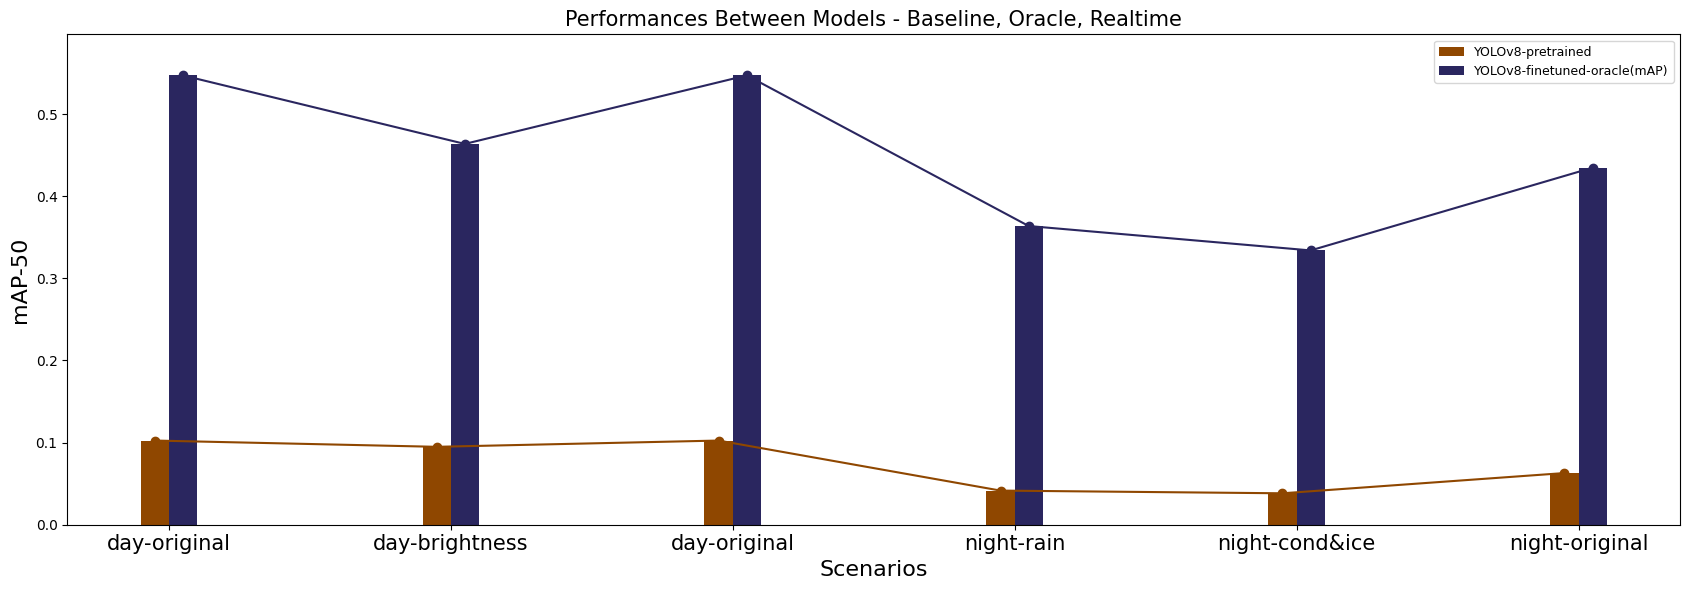

In [12]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

'''
    No noise(d)
    Brightness(d)
    No noise(d)
    Rain(n)
    Cond&ice(n)
    No noise(n)
'''
image_folders = [
    'BDD100k-daytime/images/test/',
    'BDD100k-daytime-brightness/images/test/',
    'BDD100k-daytime/images/test/',
    'BDD100k-rain/images/test/',
    'BDD100k-cond&ice/images/test/',
    'BDD100k/images/test/'
]

label_folders = [
    'BDD100k-daytime/labels/test/',
    'BDD100k-daytime-brightness/labels/test/',
    'BDD100k-daytime/labels/test/',
    'BDD100k-rain/labels/test/',
    'BDD100k-cond&ice/labels/test/',
    'BDD100k/labels/test/'
]

categories = [
    'day-original',
    'day-brightness',
    'day-original',
    'night-rain',
    'night-cond&ice',
    'night-original'
]

model99 = YOLO('yolov8l.pt')

model0 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model1 = YOLO('model/YOLOv8-large-daytime-brightness-v2/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-original/weights/best.pt')

baseline_c1 = []
oracle_c1 = []

for i in range(len(image_folders)):
    baseline_c1.append(get_score_map(model=model99, root_folder=label_folders[i], image_folder=image_folders[i], evc=100)[0])

oracle_c1.append(get_score_map(model=model0, root_folder=label_folders[0], image_folder=image_folders[0], evc=100)[0])
oracle_c1.append(get_score_map(model=model1, root_folder=label_folders[1], image_folder=image_folders[1], evc=100)[0])
oracle_c1.append(get_score_map(model=model2, root_folder=label_folders[2], image_folder=image_folders[2], evc=100)[0])
oracle_c1.append(get_score_map(model=model3, root_folder=label_folders[3], image_folder=image_folders[3], evc=100)[0])
oracle_c1.append(get_score_map(model=model4, root_folder=label_folders[4], image_folder=image_folders[4], evc=100)[0])
oracle_c1.append(get_score_map(model=model5, root_folder=label_folders[5], image_folder=image_folders[5], evc=100)[0])

x = np.arange(len(categories))
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 0.5*width, baseline_c1, width, label='YOLOv8-pretrained', color='#8F4700')
ax.plot(x - 0.5*width, baseline_c1, marker='o', color='#8F4700')

ax.bar(x + 0.5*width, oracle_c1, width, label='YOLOv8-finetuned-oracle(mAP)', color='#2A265F')
ax.plot(x + 0.5*width, oracle_c1, marker='o', color='#2A265F')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=15)
ax.legend(fontsize=9)

y_min = 0
y_max = max([max(baseline_c1), max(oracle_c1)]) + 0.05
ax.set_ylim([y_min, y_max])

fig.tight_layout()

plt.show()

In [13]:
print(baseline_c1)
print(oracle_c1)

[0.10249831911062472, 0.09487236921773258, 0.10249831911062472, 0.04154795417996869, 0.03827506366459367, 0.06292024806982757]
[0.5471853040829241, 0.4637249428005835, 0.5471853040829241, 0.363750997774377, 0.3340259028893993, 0.434800319176031]


# Scenario 2

mAP score: 0.10249831911062472
mAP score normalized: 0
mAP score: 0.09487236921773258
mAP score normalized: 0
mAP score: 0.06844028763527747
mAP score normalized: 0
mAP score: 0.03827506366459367
mAP score normalized: 0
mAP score: 0.04154795417996869
mAP score normalized: 0
mAP score: 0.06292024806982757
mAP score normalized: 0
mAP score: 0.5471853040829241
mAP score normalized: 0
mAP score: 0.4637249428005835
mAP score normalized: 0
mAP score: 0.47161982526403157
mAP score normalized: 0
mAP score: 0.3340259028893993
mAP score normalized: 0
mAP score: 0.363750997774377
mAP score normalized: 0
mAP score: 0.434800319176031
mAP score normalized: 0


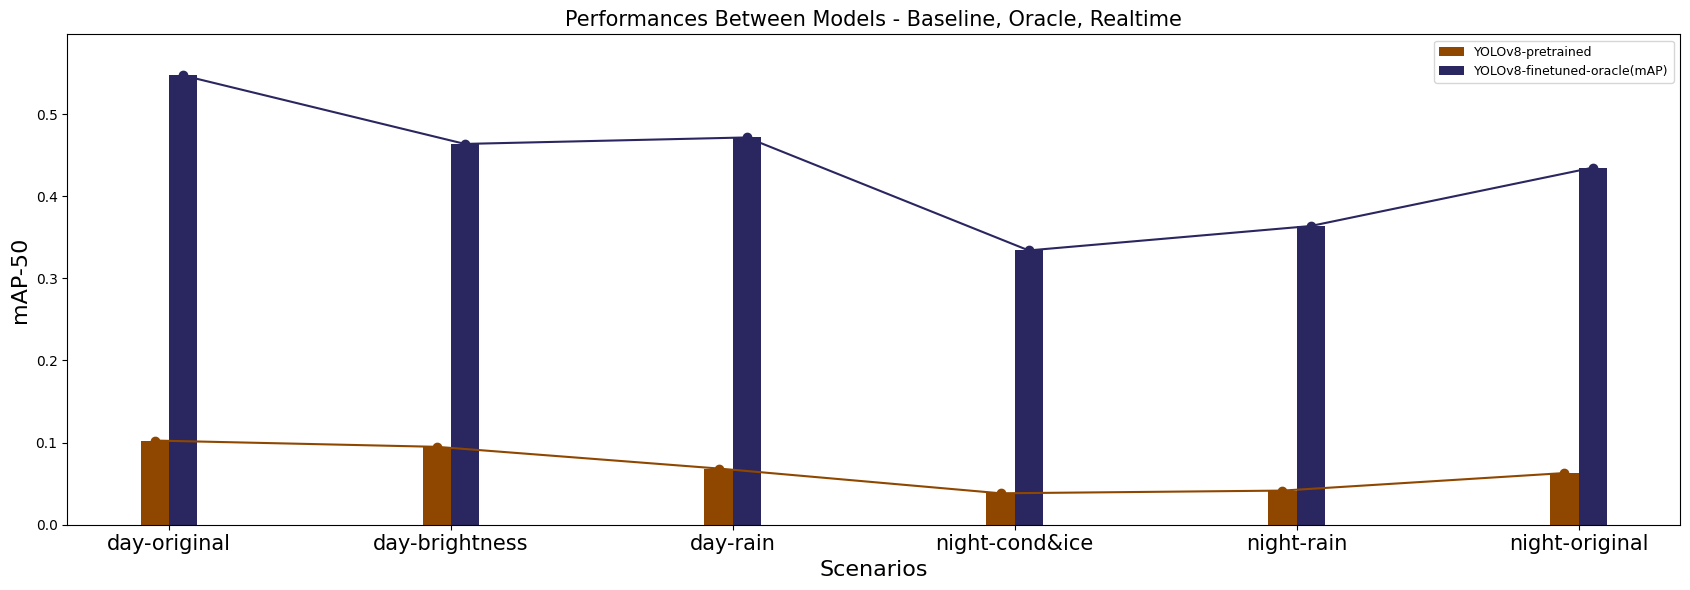

In [15]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

'''
    No noise(d)
    Brightness(d)
    Rain(d)
    Cond&ice(n)
    Rain(n)
    No noise(n)
'''
image_folders = [
    'BDD100k-daytime/images/test/',
    'BDD100k-daytime-brightness/images/test/',
    'BDD100k-daytime-rain/images/test/',
    'BDD100k-cond&ice/images/test/',
    'BDD100k-rain/images/test/',
    'BDD100k/images/test/'
]

label_folders = [
    'BDD100k-daytime/labels/test/',
    'BDD100k-daytime-brightness/labels/test/',
    'BDD100k-daytime-rain/labels/test/',
    'BDD100k-cond&ice/labels/test/',
    'BDD100k-rain/labels/test/',
    'BDD100k/labels/test/'
]

categories = [
    'day-original',
    'day-brightness',
    'day-rain',
    'night-cond&ice',
    'night-rain',
    'night-original'
]

model99 = YOLO('yolov8l.pt')

model0 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model1 = YOLO('model/YOLOv8-large-daytime-brightness-v2/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime-rain/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-original/weights/best.pt')

baseline_c2 = []
oracle_c2 = []

for i in range(len(image_folders)):
    baseline_c2.append(get_score_map(model=model99, root_folder=label_folders[i], image_folder=image_folders[i], evc=100)[0])

oracle_c2.append(get_score_map(model=model0, root_folder=label_folders[0], image_folder=image_folders[0], evc=100)[0])
oracle_c2.append(get_score_map(model=model1, root_folder=label_folders[1], image_folder=image_folders[1], evc=100)[0])
oracle_c2.append(get_score_map(model=model2, root_folder=label_folders[2], image_folder=image_folders[2], evc=100)[0])
oracle_c2.append(get_score_map(model=model3, root_folder=label_folders[3], image_folder=image_folders[3], evc=100)[0])
oracle_c2.append(get_score_map(model=model4, root_folder=label_folders[4], image_folder=image_folders[4], evc=100)[0])
oracle_c2.append(get_score_map(model=model5, root_folder=label_folders[5], image_folder=image_folders[5], evc=100)[0])

x = np.arange(len(categories))
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 0.5*width, baseline_c2, width, label='YOLOv8-pretrained', color='#8F4700')
ax.plot(x - 0.5*width, baseline_c2, marker='o', color='#8F4700')

ax.bar(x + 0.5*width, oracle_c2, width, label='YOLOv8-finetuned-oracle(mAP)', color='#2A265F')
ax.plot(x + 0.5*width, oracle_c2, marker='o', color='#2A265F')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=15)
ax.legend(fontsize=9)

y_min = 0
y_max = max([max(baseline_c1), max(oracle_c1)]) + 0.05
ax.set_ylim([y_min, y_max])

fig.tight_layout()

plt.show()

In [16]:
print(baseline_c2)
print(oracle_c2)

[0.10249831911062472, 0.09487236921773258, 0.06844028763527747, 0.03827506366459367, 0.04154795417996869, 0.06292024806982757]
[0.5471853040829241, 0.4637249428005835, 0.47161982526403157, 0.3340259028893993, 0.363750997774377, 0.434800319176031]


# Scenario 3

mAP score: 0.08175758536637806
mAP score normalized: 0
mAP score: 0.10249831911062472
mAP score normalized: 0
mAP score: 0.06844028763527747
mAP score normalized: 0
mAP score: 0.05585020347586206
mAP score normalized: 0
mAP score: 0.03827506366459367
mAP score normalized: 0
mAP score: 0.04154795417996869
mAP score normalized: 0
mAP score: 0.47673242517626185
mAP score normalized: 0
mAP score: 0.5471853040829241
mAP score normalized: 0
mAP score: 0.47161982526403157
mAP score normalized: 0
mAP score: 0.40313150965155314
mAP score normalized: 0
mAP score: 0.3340259028893993
mAP score normalized: 0
mAP score: 0.363750997774377
mAP score normalized: 0


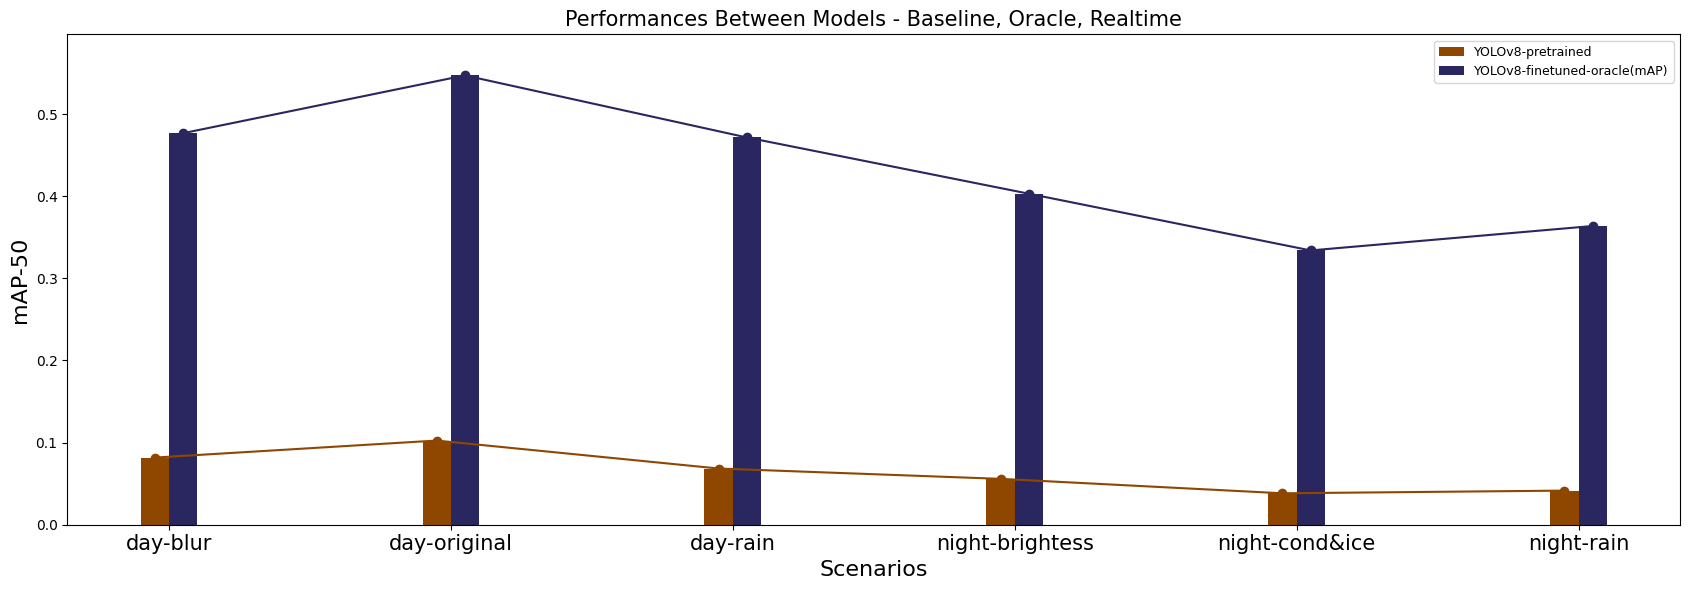

In [17]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

'''
    Blur(d)
    No noise(d)
    Rain(d)
    Brightness(n)
    Cond&ice(n)
    Rain(n)
'''
image_folders = [
    'BDD100k-daytime-blur/images/test/',
    'BDD100k-daytime/images/test/',
    'BDD100k-daytime-rain/images/test/',
    'BDD100k-brightness/images/test/',
    'BDD100k-cond&ice/images/test/',
    'BDD100k-rain/images/test/'
]

label_folders = [
    'BDD100k-daytime-blur/labels/test/',
    'BDD100k-daytime/labels/test/',
    'BDD100k-daytime-rain/labels/test/',
    'BDD100k-brightness/labels/test/',
    'BDD100k-cond&ice/labels/test/',
    'BDD100k-rain/labels/test/'
]

categories = [
    'day-blur',
    'day-original',
    'day-rain',
    'night-brightess',
    'night-cond&ice',
    'night-rain'
]

model99 = YOLO('yolov8l.pt')

model0 = YOLO('model/YOLOv8-large-daytime-blur/weights/best.pt')
model1 = YOLO('model/YOLOv8-large-daytime/weights/best.pt')
model2 = YOLO('model/YOLOv8-large-daytime-rain/weights/best.pt')
model3 = YOLO('model/YOLOv8-large-night-brightness/weights/best.pt')
model4 = YOLO('model/YOLOv8-large-night-cond&ice/weights/best.pt')
model5 = YOLO('model/YOLOv8-large-night-rain/weights/best.pt')

baseline_c3 = []
oracle_c3 = []

for i in range(len(image_folders)):
    baseline_c3.append(get_score_map(model=model99, root_folder=label_folders[i], image_folder=image_folders[i], evc=100)[0])

oracle_c3.append(get_score_map(model=model0, root_folder=label_folders[0], image_folder=image_folders[0], evc=100)[0])
oracle_c3.append(get_score_map(model=model1, root_folder=label_folders[1], image_folder=image_folders[1], evc=100)[0])
oracle_c3.append(get_score_map(model=model2, root_folder=label_folders[2], image_folder=image_folders[2], evc=100)[0])
oracle_c3.append(get_score_map(model=model3, root_folder=label_folders[3], image_folder=image_folders[3], evc=100)[0])
oracle_c3.append(get_score_map(model=model4, root_folder=label_folders[4], image_folder=image_folders[4], evc=100)[0])
oracle_c3.append(get_score_map(model=model5, root_folder=label_folders[5], image_folder=image_folders[5], evc=100)[0])

x = np.arange(len(categories))  
width = 0.1

fig, ax = plt.subplots(figsize=(17, 6))

ax.bar(x - 0.5*width, baseline_c3, width, label='YOLOv8-pretrained', color='#8F4700')
ax.plot(x - 0.5*width, baseline_c3, marker='o', color='#8F4700')

ax.bar(x + 0.5*width, oracle_c3, width, label='YOLOv8-finetuned-oracle(mAP)', color='#2A265F')
ax.plot(x + 0.5*width, oracle_c3, marker='o', color='#2A265F')

ax.set_xlabel('Scenarios', fontsize=16)
ax.set_ylabel('mAP-50', fontsize=16)
ax.set_title('Performances Between Models - Baseline, Oracle, Realtime', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=15)
ax.legend(fontsize=9)

y_min = 0
y_max = max([max(baseline_c3), max(oracle_c3)]) + 0.05
ax.set_ylim([y_min, y_max])

fig.tight_layout()

plt.show()

In [18]:
print(baseline_c3)
print(oracle_c3)

[0.08175758536637806, 0.10249831911062472, 0.06844028763527747, 0.05585020347586206, 0.03827506366459367, 0.04154795417996869]
[0.47673242517626185, 0.5471853040829241, 0.47161982526403157, 0.40313150965155314, 0.3340259028893993, 0.363750997774377]
